# План домашних заданий


- Описание задачи и знакомство с данными
- Домашнее задание 1. Генерация и фильтрация признаков
- Домашнее задание 2. Прогноз времени и вида поломки машин, настройка ML-модели
- Дополнительное задание. Визуализация прогнозов, ошибок модели и важности признаков
- Домашнее задание 3. Оптимизация. Тюнинг гиперпараметров с помощью `Optuna`
- Домашнее задание 4. Блендинг
- Домашнее задание 5. Парсинг внешних данных и оптимизация памяти
- Отправка финального решения на лидерборд на Kaggle

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# <center id="part0"> Описание задачи

**Предыстория:**  мы работаем с каршеринговой компанией, которая управляет крупным автопарком машин. Наша цель — предотвратить длительные периоды простоя машин из-за поломок через своевременное обслуживание и ремонт.


**Идея для решения проблемы:** создать приоритизированный список обхода машин. Этот список поможет технической бригаде сосредоточиться на автомобилях, которые наиболее вероятно выйдут из строя в ближайшее время.


**Как компания решает задачу:**

* Собирает данные о поездках и состоянии машин до поломок.

* Нанимает Data Scientist, чтобы он смог использовать эти данные для анализа и прогнозирования характера поломок.

**Важный момент**: задачи этого специалиста (Data Scientist) предстоит выполнять вам.

## <center> Знакомство с данными

### Информация про машины с таргетом (основной датасет)

In [2]:
car_train = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/car_train.csv')
car_train.sample(5)

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class
1164,O20152474b,Kia Rio X-line,economy,petrol,4.70,2013,37888,2020,53.58,engine_check
2222,f-1883871J,VW Polo,economy,petrol,4.22,2013,49285,2021,43.47,break_bug
446,k55997232L,Hyundai Solaris,economy,petrol,4.76,2014,65451,2014,34.02,gear_stick
1105,T12624719o,Renault Sandero,standart,petrol,4.18,2013,38993,2018,44.77,another_bug
646,Y-4198316J,VW Tiguan,economy,petrol,4.86,2014,59714,2020,71.85,engine_ignition


- `car_id` — идентификатор машины
- `model` / `car_type` / `fuel_type` — марка, класс и тип топлива машины
- `car_rating` / `riders` — общий рейтинг и общее число поездок к концу 2021 года
- `year_to_start` / `year_to_work` — год выпуска машины и год начала работы в автопарке
- `target_reg` — количество дней до поломки
- `target_class` — класс поломки (всего 9 видов)

### Информация про поездки

In [3]:
rides_info = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/rides_info.csv')
rides_info.sample(5)

,user_id,car_id,ride_id,ride_date,rating,ride_duration,ride_cost,speed_avg,speed_max,stop_times,distance,refueling,user_ride_quality,deviation_normal
377887,Y38145304r,a87403235S,c1K,2020-03-11,8.47,51,708,41,56.245998,0,2154.663684,0,-1.971607,2.522
495897,z51821700c,i93529341g,Q1R,2020-03-31,3.04,23,361,36,53.000000,2,830.184584,0,6.300553,-11.013
467925,s12724295c,h-1344515n,X1o,2020-01-22,4.95,22,302,77,160.768588,0,894.000461,0,3.124802,25.602
399112,Y47220550q,c-5615180M,G1i,2020-03-09,7.52,234,7014,35,80.000000,3,1735.067497,0,1.717144,-13.844
10924,E10966190J,A18130070W,p1X,2020-03-13,5.30,44,435,61,157.740043,0,2592.375128,0,-23.959351,48.462


- `user_id` / `car_id` / `ride_id` — идентификаторы водителя, машины, поездки соответственно
- `ride_date` / `rating` — дата поездки и рейтинг, поставленный водителем
- `ride_duration` / `distance` / `ride_cost` —  длительность (время),  пройденное расстояние, стоимость поездки
- `speed_avg` / `speed_max` — средняя и максимальная скорости поездки соответственно
- `stop_times` / `refueling` — количество остановок (паузы) и флаг: была ли дозаправка
- `user_ride_quality` — оценка манеры вождения водителя машины, определенная скоринговой ML-системой сервиса
- `deviation_normal` — общий показатель датчиков о состоянии машины, относительно эталонных показателей (нормы)

### Информация про водителей

In [4]:
driver_info = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/driver_info.csv')
driver_info.sample(5)

,age,user_rating,user_rides,user_time_accident,user_id,sex,first_ride_date
6686,37,8.5,113,11.0,I21477729A,0,2019-10-16
11498,50,9.0,125,8.0,g13141625N,0,2019-12-18
6488,25,8.6,1121,24.0,w16276923C,1,2018-10-26
2696,19,7.5,1301,13.0,c45195256p,1,2018-9-11
8,18,9.3,425,18.0,r77865210A,1,2020-6-4


- `user_id` / `age` / `sex` — идентификатор, возраст и пол водителя, соответственно
- `user_rating` — общий рейтинг пользователя за все поездки к концу 2021 года
- `user_rides` — общее количество поездок к концу 2021 года
- `user_time_accident` — число инцидентов (это могли быть аварии/штрафы/эвакуация машины)  
- `first_ride_date` — дата первой поездки

### Информация про ремонт машин

In [5]:
fix_info = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/fix_info.csv')
fix_info.sample(5)

,car_id,worker_id,fix_date,work_type,destroy_degree,work_duration
114661,f16491132W,RY,2019-1-5 1:55,refuel_check,1.0,18
69489,N-2240902Z,KM,2019-2-22 0:4,repair,6.5,34
62137,v-1334609Q,XF,2018-2-2 18:14,repair,5.4,14
136137,X-1892335q,SG,2021-4-10 5:57,reparking,1.0,23
24770,b-7106735g,YY,2019-12-9 11:53,reparking,1.0,32


- `worker_id` / `car_id` — идентификатор работника и машины
- `work_type` / `work_duration` — тип и длительность (в часах) проводимой работы
- `destroy_degree` — степень износа/поврежденности машины в случае поломки
- `fix_date` — время начала ремонта (снятия машины с линии)

# Домашнее задание 1. Генерация и фильтрация признаков

<center> <img src="https://ucarecdn.com/bf4c772d-b67a-42ae-a48b-cfd83910b0a2/" width=700>

<div class="alert alert-info">

**Цель блока** — сгенерировать признаки из дополнительных датасетов и добавить их к основному датасету, произвести фильтрацию признаков.

    
## Задание 1. Генерация признаков из дополнительных датасетов (6 баллов)

<div class="alert alert-info">

1. Возьмите датасет `rides_info` с информацией о поездках и проведите группировку по каждой машине отдельно.

2. Для каждой машины (то есть для каждого `car_id`) подсчитайте несколько признаков:
  - минимальный рейтинг за все поездки;
  - средний рейтинг за все поездки;
  - общее количество километров, которое машина проехала;
  - максимальная скорость;
  - общее количество поездок для каждой машины.

3. Добавьте минимум 3 признака на свой выбор.

4. Сделайте соединение таблиц — вспомните про методы соединения и выберите подходящий для этого случая.

5. Подключите информацию про водителей (`driver_info`) и про ремонт машин (`fix_info`). Добавьте минимум 3 любых признака с каждого датасета.


<h4> Критерии оценивания </h4>
    
- Добавлены 5 обязательных и минимум 3 любых признака из датасета `rides_info` — 2 балла.
- Добавлены минимум 3 любых признака из датасета `driver_info` — 2 балла.
- Добавлены минимум 3 любых признака из датасета `fix_info` — 2 балла.

</div>

<div class="alert alert-success">
    
<h4> Советы по Feature Engineering</h4>
    
- Начинайте с сырых данных.
- Используйте все доступные данные. Покрывайте признаками всю имеющуюся информацию в данных.
- Формулируйте предположения: от чего зависит таргет?
- Смотрите визуально на классы/ошибки и делайте предположения. Какие полезны?
- Помните, что слишком много признаков может быть вредно. Потом придется отфильтровывать.
    
<h4> Полезные источники </h4>
    
- Занятие про Feature Engineering.
- Занятие про Feature Selection.
- [Max Kuhn and Kjell Johnson. Feature Engineering and Selection: A Practical Approach for Predictive Models](http://www.feat.engineering/).

### Пример расчета признака

In [6]:
# Для каждой машины несколько признаков
rides_group = rides_info.groupby('car_id', as_index=False).agg(
    mean_rating = ('rating', 'mean'),
    min_rating = ('rating', 'min'),
    all_distance = ('distance', 'sum'),
    speed_max = ('speed_max', 'max'),
    alL_rides = ('ride_id', 'count'),

    # добавляю сразу признаки на свой выбор
    avg_ride_cost = ('ride_cost', 'mean'),
    avg_speed = ('speed_avg', 'mean'),
    mean_distance = ('distance', 'mean'),
)

# Cоединение таблиц
data = pd.merge(car_train, rides_group, on='car_id')

# Подключение информации про водителей и про ремонт машин
data = pd.merge(data, rides_info[['car_id', 'user_id']], on='car_id')
data = pd.merge(data, driver_info[['user_id', 'age', 'user_rating', 'user_rides']], on='user_id')
data = pd.merge(data, fix_info[['car_id', 'worker_id', 'fix_date', 'work_type']], on='car_id')

data.head()

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,...,avg_ride_cost,avg_speed,mean_distance,user_id,age,user_rating,user_rides,worker_id,fix_date,work_type
0,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,...,20106.873563,44.66092,69777.646008,n14703870u,38,7.4,268,PG,2019-8-10 9:29,reparking
1,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,...,20106.873563,44.66092,69777.646008,n14703870u,38,7.4,268,HH,2019-2-9 10:49,repair
2,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,...,20106.873563,44.66092,69777.646008,n14703870u,38,7.4,268,UF,2020-4-8 10:23,reparking
3,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,...,20106.873563,44.66092,69777.646008,n14703870u,38,7.4,268,LC,2019-5-23 10:42,reparking
4,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,...,20106.873563,44.66092,69777.646008,n14703870u,38,7.4,268,AF,2020-7-24 18:32,repair


## Задание 2. Применение методов фильтрации признаков (4 балла)

<center> <img src="https://ucarecdn.com/d1b4bc78-fd04-44fb-bdbf-0a63355b7384/" width=700>

1. Выберите и примените любые 3 (можно и больше) метода фильтрации, которые указаны выше или в ноутбуке по фильтрации из полезных ссылок.
2. Проинтерпретируйте результаты и сделайте выводы.


<h4> Критерии оценивания </h4>
    
- Применены методы фильтрации — 1 балл за каждый метод, максимум 3 балла.
- Сделаны выводы на основе примененных методов —1 балл.
</div>

### Советы по Feature Selection

<div class="alert alert-info">

<h3><center>Зачем отбирать признаки</center></h3>
    
**Основные причины**:
    
- Главная причина: с увеличением количества признаков часто падает точность предсказания модели, а некоторые модели и вовсе перестают адекватно работать. Так происходит, если в данных большое количество мусорных фичей (почти не коррелирующих с таргетом).

- Если фичей очень много, то данные перестают помещаться в память и существенно увеличивают время обучения модели, особенно если мы тестируем несколько алгоритмов или ансамбль. Также важно учитывать, что платформы имеют ограничения на длительность одной сессии (в Kaggle — 12 часов) и лимиты по потребляемой памяти.

- Даже если точность не снижается, есть риск, что модель опирается на шумные фичи, что снизит стабильность прогноза на приватной выборке.


<b>Что удалить сразу:</b>
    
- константы;
- уникальные значения (в том числе в тесте; как правило, это ID-шники по типу `car_id`).
    
<b>Какие методы использовать:</b>
    
- `Линейная корреляция`.
- `Phik` — тоже корреляция, но на стероидах ([туториал на Medium](https://towardsdatascience.com/phik-k-get-familiar-with-the-latest-correlation-coefficient-9ba0032b37e7)).
- `Permutation importance` (из `scikit-learn`).
- `SHAP values` (из библиотеки `shap`).
- `CatBoost Feature Selection` (рекурсивные методы).
    

In [7]:
# Удаление констант и уникальных значений
columns_with_id = [col for col in data.columns if '_id' in col]

data = data.loc[:, data.apply(pd.Series.nunique) != 1]
data = data.drop(columns_with_id, axis=1)
data = data.dropna(axis=1)
data.head()

,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,mean_rating,...,all_distance,speed_max,avg_ride_cost,avg_speed,mean_distance,age,user_rating,user_rides,fix_date,work_type
0,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,4.737759,...,1.214131e+07,180.855726,20106.873563,44.66092,69777.646008,38,7.4,268,2019-8-10 9:29,reparking
1,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,4.737759,...,1.214131e+07,180.855726,20106.873563,44.66092,69777.646008,38,7.4,268,2019-2-9 10:49,repair
2,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,4.737759,...,1.214131e+07,180.855726,20106.873563,44.66092,69777.646008,38,7.4,268,2020-4-8 10:23,reparking
3,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,4.737759,...,1.214131e+07,180.855726,20106.873563,44.66092,69777.646008,38,7.4,268,2019-5-23 10:42,reparking
4,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,4.737759,...,1.214131e+07,180.855726,20106.873563,44.66092,69777.646008,38,7.4,268,2020-7-24 18:32,repair


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13970460 entries, 0 to 13970459
Data columns (total 21 columns):
 #   Column         Dtype  
---  ------         -----  
 0   model          object 
 1   car_type       object 
 2   fuel_type      object 
 3   car_rating     float64
 4   year_to_start  int64  
 5   riders         int64  
 6   year_to_work   int64  
 7   target_reg     float64
 8   target_class   object 
 9   mean_rating    float64
 10  min_rating     float64
 11  all_distance   float64
 12  speed_max      float64
 13  avg_ride_cost  float64
 14  avg_speed      float64
 15  mean_distance  float64
 16  age            int64  
 17  user_rating    float64
 18  user_rides     int64  
 19  fix_date       object 
 20  work_type      object 
dtypes: float64(10), int64(5), object(6)
memory usage: 2.3+ GB


In [9]:
data.shape

(13970460, 21)

Чересчур много значений получилось, убавлю до 500 для оптимизации

In [10]:
data = data.sample(n=500)

In [11]:
data.shape

(500, 21)

In [13]:
# Удалю еще столбцы для оптимизации, так как очень много данных
cols_drop = [
    'mean_rating',
    'min_rating',
    'all_distance',
    'avg_ride_cost',
    'speed_max',
    'avg_speed',
    'mean_distance',
    'year_to_work',
    'target_reg',
]

data = data.drop(columns = cols_drop)

interval columns not set, guessing: ['car_rating', 'year_to_start', 'riders', 'age', 'user_rating', 'user_rides']


/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable fix_date is large: 77964. Are you sure this is not an interval variable? Analysis for pairs of variables including fix_date can be slow.
  warnings.warn(


                  model  car_type  fuel_type  car_rating  year_to_start  \
model          1.000000  1.000000   1.000000    0.249718       0.578220   
car_type       1.000000  1.000000   0.694427    0.090503       0.281361   
fuel_type      1.000000  0.694427   1.000000    0.073095       0.025406   
car_rating     0.249718  0.090503   0.073095    1.000000       0.132854   
year_to_start  0.578220  0.281361   0.025406    0.132854       1.000000   
riders         0.550906  0.312185   0.057774    0.218532       0.956550   
target_class   0.311372  0.203310   0.050828    0.135708       0.112042   
age            0.094838  0.060768   0.060821    0.017029       0.024745   
user_rating    0.261916  0.155162   0.266044    0.024364       0.021926   
user_rides     0.083842  0.072296   0.053640    0.016468       0.018408   
fix_date       0.999962  0.999784   0.999563    0.999829       0.999839   
work_type      0.038810  0.009587   0.016191    0.022562       0.012905   

                 riders 

Text(0.5, 1.0, 'Phik Matrix')

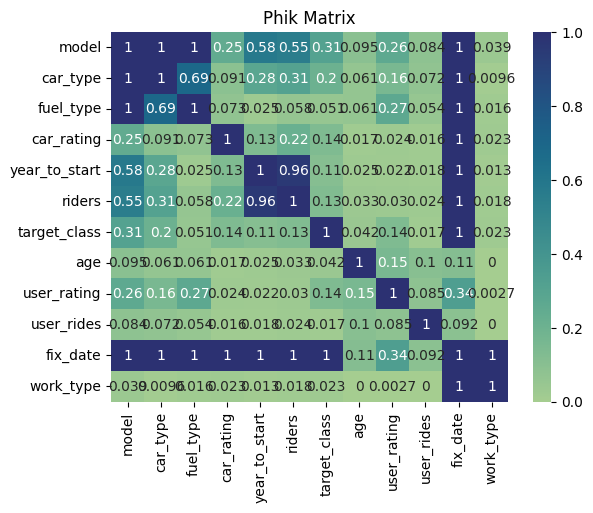

In [ ]:
# Phik

!pip install phik

from phik import report
phik_matrix = data.phik_matrix()

print(phik_matrix)

sns.heatmap(phik_matrix, annot=True, cmap='crest')
plt.title("Phik Matrix")

Прошу прощения за "скукоженный график". Очень долго ждал выполнения ячейки, переделывать не стал.

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 5004204 to 1053273
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   model          500 non-null    object 
 1   car_type       500 non-null    object 
 2   fuel_type      500 non-null    object 
 3   car_rating     500 non-null    float64
 4   year_to_start  500 non-null    int64  
 5   riders         500 non-null    int64  
 6   target_class   500 non-null    object 
 7   age            500 non-null    int64  
 8   user_rating    500 non-null    float64
 9   user_rides     500 non-null    int64  
 10  fix_date       500 non-null    object 
 11  work_type      500 non-null    object 
dtypes: float64(2), int64(4), object(6)
memory usage: 50.8+ KB


In [18]:
# CatBoost

!pip install catboost

from catboost import CatBoostRegressor, Pool, CatBoostClassifier
from sklearn.model_selection import train_test_split

cat_cols = list(data.select_dtypes(include=['object']).columns)
cat_cols.remove('target_class')

X = data.drop(columns = 'target_class')
y = data['target_class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = CatBoostClassifier(random_state=42, cat_features=cat_cols)
model.fit(X_train, y_train, plot=True)

results = model.get_feature_importance()
print(results)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.075002
0:	learn: 2.1883331	total: 187ms	remaining: 3m 7s
1:	learn: 2.1790177	total: 335ms	remaining: 2m 46s
2:	learn: 2.1669002	total: 511ms	remaining: 2m 49s
3:	learn: 2.1565678	total: 686ms	remaining: 2m 50s
4:	learn: 2.1430000	total: 837ms	remaining: 2m 46s
5:	learn: 2.1330589	total: 968ms	remaining: 2m 40s
6:	learn: 2.1316965	total: 973ms	remaining: 2m 18s
7:	learn: 2.1180129	total: 1.15s	remaining: 2m 22s
8:	learn: 2.1088313	total: 1.27s	remaining: 2m 19s
9:	learn: 2.1064753	total: 1.28s	remaining: 2m 7s
10:	learn: 2.0947524	total: 1.44s	remaining: 2m 9s
11:	learn: 2.0898619	total: 1.59s	remaining: 2m 11s
12:	learn: 2.0886143	total: 1.62s	remaining: 2m 2s
13:	learn: 2.0879017	total: 1.64s	remaining: 1m 55s
14:	learn: 2.0751321	total: 1.81s	remaining: 1m 58s
15:	learn: 2.0688417	total: 1.9s	remaining: 1m 56s
16:	learn: 2.0574284	total: 2s	remaining: 1m 55s
17:	learn: 2.0517473	total: 2.07s	remaining: 1m 52s
18:	learn: 2.0471158	total: 2.17s	remaining: 1m 52s


In [24]:
results = model.get_feature_importance(prettified=True)
results

,Feature Id,Importances
0,model,27.930875
1,work_type,21.472100
2,car_type,15.033556
3,user_rides,8.241612
4,riders,6.772114
5,user_rating,6.697910
6,car_rating,6.603115
7,age,6.437227
8,year_to_start,0.791495
9,fuel_type,0.012674


In [31]:
X.columns

Index(['model', 'car_type', 'fuel_type', 'car_rating', 'year_to_start',
       'riders', 'age', 'user_rating', 'user_rides', 'fix_date', 'work_type'],
      dtype='object')

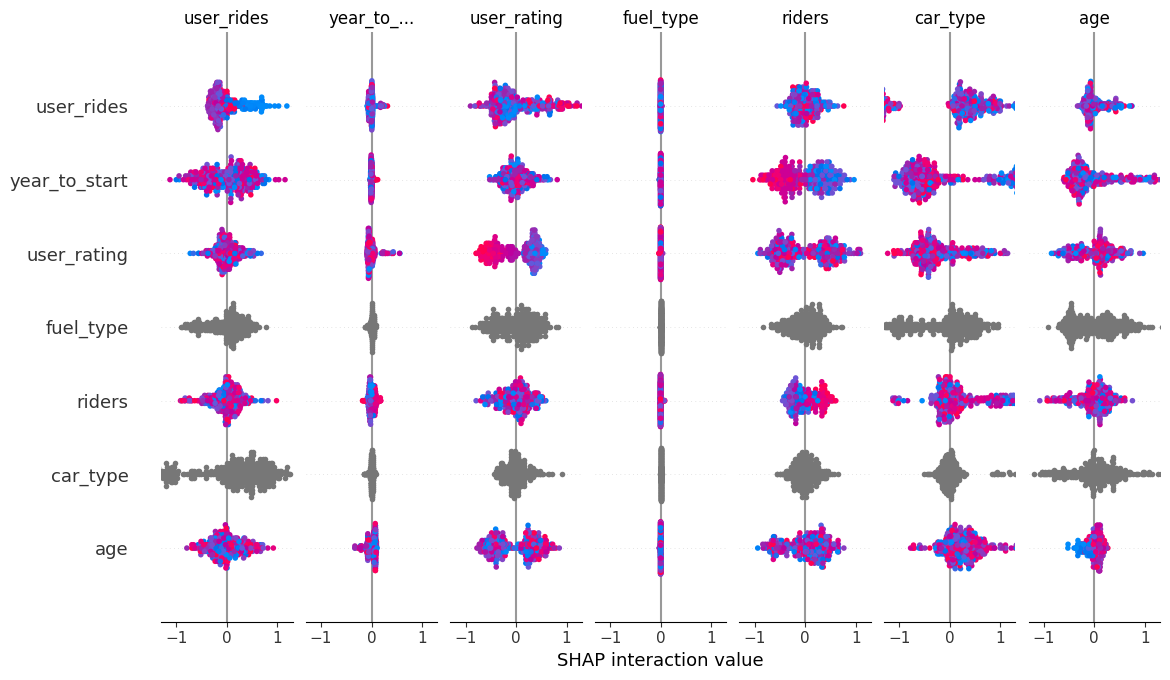

In [32]:
# Shap

!pip install shap

import shap

explain = shap.TreeExplainer(model)
values = explain.shap_values(X_train)

shap.summary_plot(values, X_train)

# Домашнее задание 2. Прогноз времени и вида поломки машин. Настройка ML-модели

<div class="alert alert-info">

**Цель блока** — составить тренировочную и валидационную выборки, произвести обучение модели `CatBoostClassifier` на тренировочной части и оценить качество на валидационной.

##Обучение первой модели (5 баллов)

1.   Новый пункт
2.   Новый пункт



1. Классифицируйте признаки на типы (категориальные, числовые, таргеты).

2. Выделите в `X` только признаки, а в `Y` — таргет (для задачи классификации).

3. Сделайте разделение данных на *обучающую* и *валидационную* выборки (не забывайте про воспроизводимость результатов).

4. Создайте и обучите `CatBoostClassifier` модель (настраивать гиперпараметры сейчас не обязательно).

5. Проведите оценку вашей модели, используя метрику `accuracy`.


<h4> Критерии оценивания </h4>
    
- По 1 баллу за каждый корректно выполненный пункт.

</div>

In [ ]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
features2drop = [...] # то, что надо выбросить
targets = [...] # таргеты
cat_features = [...] # категориальные признаки

num_features = [...] # числовые признаки

print('Категориальные признаки:', len(cat_features), cat_features)
print('Числовые признаки:', len(num_features), num_features)
print('Целевые переменные', targets)

In [ ]:
# YOUR CODE HERE

# Дополнительное задание. Визуализация прогнозов, ошибок модели и важности признаков

<div class="alert alert-info">

**Цель блока** — визуализировать результаты прогнозирования, ошибки модели и важность признаков для лучшего понимания и анализа модели.

## Визуализация (5 баллов)

   
1. Визуализируйте важность признаков встроенным методом в `CatBoost`  (помните, что не стоит сильно доверять этому рейтингу важности, т. к. для сильно скоррелированных признаков важность делится пополам — оба признака могут улететь вниз).

2. Постройте `waterfall_plot` из библиотеки `SHAP` (подробнее во втором ноутбуке из полезных ссылок ниже).
    
3. Постройте `classification_report` из библиотеки `scikit-learn`.

4. Постройте и визуализируйте матрицу смежности (`confusion_matrix`), посмотрите, в каких классах модель больше всего ошибается.
    
5. Для каждого графика/примененного метода проинтерпретируйте результаты и сделайте выводы.


<h4> Критерии оценивания </h4>
    
- По 1 баллу за каждый корректно выполненный пункт.
    
</div>

<div class="alert alert-success">

Визуализация может помочь даже после того, как мы **уже обучили** какую-нибудь модель. Например:

- Понять, что мешает модели или чего не хватает, чтобы не допускать ошибки.
- Сделать выводы, как можно улучшить точность в последующих экспериментах.
- Визуализировать ошибки модели.
- Отсеять лишние признаки.
- Найти идеи для новых признаков.
- Все зависит от типа ваших данных.

<h3> Полезные источники </h3>
    
- Занятие про визуализацию и Seaborn.
- Занятие про продвинутую визуализацию и анализ ошибок модели.

</div>    

In [ ]:
# YOUR CODE HERE

# Домашнее задание 3. Оптимизация. Тюнинг гиперпараметров с помощью `Optuna`

<div class="alert alert-info">

**Цель блока** — улучшить качество предсказания, произведя подбор гиперпараметров для модели с помощью `Optuna`.

## Подбор гиперпараметров (3 балла)

1. Напишите `objective` функцию и запустите `Optuna`.
2. Подберите гиперпараметры для `CatBoostClassifier` (минимум 3).
3. Обучите модель с новыми гиперпараметрами, сравните качество и сделайте выводы.

    
<h4> Критерии оценивания </h4>
    
- 1 балл за каждый корректно выполненный пункт.
    
</div>

In [ ]:
# YOUR CODE HERE

### Общая информация по `Optuna`

#### Ключевые особенности <code>Optuna</code>



- Легковесность и универсальность — можно подбирать оптимальные параметры под любые функции и метрики.
- SOTA-алгоритмы, адаптированные для поиска гиперпараметров.
- Параллелизация и различные методы прунинга.
- Встроенная визуализация.
- Интеграция со множеством популярных библиотек (бустинги, sklearn, PyTorch, W&B и другие).

Разберем Optuna по частям, чтобы понять, как ее использовать.

#### <code>Study</code>: оптимизация, базирующаяся на <code>Objective</code> функции



В `Objective`-функцию нужно написать код подсчета метрики, которую возвращаем. `Objective` вызывается Optuna много раз для подбора лучших параметров.
```python
def objective(trial, ...):
    # calculate score...
    return score
```

<h4> <code>Trial</code> — одно выполнение <code>Objective</code>-функции</h4>

В `trial`-объекте мы передаем параметры для «перебора», используя для каждого типа свой метод. Например:

```python
# метод `suggest_float` показывает, что перебираем `float` значения, от 0 и до 1.5 границы
param = trial.suggest_float('param', 0, 1.5)

# Категориальное значение
loss_function = trial.suggest_categorical('loss', ['Logloss', 'CrossEntropy'])

# Целочисленное значение
depth = trial.suggest_int('depth', 5, 8)

# Равномерное распределение
learning_rate = trial.suggest_uniform('learning_rate', 0.0, 1.0)
```

#### `Study` parameters

Инициализируем объект `study`, который начнет перебор и сохранит в себе историю результатов.
Если мы стараемся увеличить метрику, а не уменьшить ошибку, то используем `create_study(direction='maximize')`.
```python
study = optuna.create_study()
study.optimize(objective, n_trials=10)
```

<div class="alert alert-info">
    
В [`Optuna`](https://optuna.readthedocs.io/en/stable/index.html) реализовано несколько методов (`sampler`) подбора параметров (в том числе классические):
* `GridSampler`
* `RandomSampler`
* `Tree-Structed Parzen Estimator` (`TPESampler` — самый популярный, дефолтный)
* `BruteForceSampler`
* [Другие 4 метода](https://optuna.readthedocs.io/en/stable/reference/samplers/index.html#module-optuna.samplers) (можно написать собственный семплер)

### Советы по перебору параметров

- Иметь понимание важности параметров.
- Число `iterations` лучше взять с запасом и зафиксировать, при этом ограничив через `early_stopping_rounds`.
- Подсмотреть или чувствовать диапазоны и шаг значений.
- Исключить то, что перебирать не нужно (`random_seed` , `eval_metric`, `thread_count` и прочее).
- Используйте информацию с прошлых попыток.

# Домашнее задание 4. Блендинг

<div class="alert alert-info">

**Цель блока** — улучшить качество предсказания, объединив несколько моделей вместе методом блендинга.

## Задание 6. Блендинг (10 баллов)

1. Построить и обучить модели:
    - `CatBoostClassifier`,
    - `LightGBMClassifier (goss)`,
    - `XGBoostClassifier (dart)`,
    - `RandomForestClassifier`.
2. Сделать предсказания каждой моделью, оценить качество.
3. Реализовать блендинг двумя способами, оценить качество и сравнить с предыдущим пунктом:
    - `Hard Voting` —  метод, при котором делаем голосование всех моделей и выбираем самый популярный класс.
    - `Soft Voting` —  метод, при котором мы складываем вероятности предсказания всех моделей по каждому классу и потом выбираем самый класс с максимальной суммой.
    
<h4> Критерии оценивания </h4>
    
- Обучены 4 модели — 1 балл за каждую обученную модель, всего 4 балла.
- Для модели проведен подбор гиперпараметров — 0,5 балла за каждый параметр, всего 2 балла.
- Сделаны предсказания каждой модели и оценено качество — 1 балл.
- Реализован `Hard Voting` — 1 балл.
- Реализован `Soft Voting` — 1 балл.
- Сделаны выводы — 1 балл.
    
</div>

In [ ]:
# YOUR CODE HERE

### Общая информация о блендинге

**Основная идея** — взять от каждого алгоритма лучшее и совместить несколько разных ML-моделей в одну.

Что это дает:
- Увеличивается обобщающая способность финальной модели и качество улучшается.
- Модель становится более стабильной, что позволяет не слететь на приватном лидерборде.

Особенно хорошо накидывает блендинг, если смешиваемые модели имеют разную природу — например, нейронные сети, kNN и решающие деревья. Они выучивают разные зависимости и хорошо дополняют друг друга.

</div>

# <center id="part6"> Отправка финального решения на лидерборд на Kaggle

<div class="alert alert-info">

**Цель блока** — сделать предсказание с помощью блендинга для тестовой части датасета, отправить результат [в соревнование на Kaggle](https://www.kaggle.com/competitions/competative-data-science-course-by-data-feeling/overview).

## Задание 8. Предсказание на тестовом датасете и отправка на Kaggle

1. Сделать предобработку для тестового датасета, присоединить к нему информацию из других датасетов и добавить признаки, которые генерировали для тренировочного датасета.
2. Сделать предсказания каждой моделью, которую хотите включить в ансамбль, но минимум их должно быть 3.
3. Сделать блендинг с помощью `Hard Voting` или `Soft Voting` на ваш выбор.
4. Сохранить результат предсказания в `csv` файл и отправить решение на Kaggle.
    
<h4> Критерии оценивания </h4>
    
- 0 баллов за задание, если итоговый скор на лидерборде меньше чем `0.9`.
- 1 балл за каждый выполненный пункт.

</div>

In [ ]:
car_test = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/car_test.csv')
car_test.head(3)

In [ ]:
# YOUR CODE HERE

### Советы по отправке кода на Kaggle



Если пишете код на `Kaggle`, то для отправки решения:

1. Нажать Save Version.
2. Проверить, что в Advanced Settings выбрано «Всегда сохранять результаты ноутбука».
3. Выбрать тип сохранения Save & Run All (Commit).
4. Нажать кнопку Save.